# Import necessary modules

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler

# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

ImportError: cannot import name '_get_n_jobs' from 'sklearn.utils' (/Users/glendawee/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py)

# Handle Imbalanced Dataset

## Exploratory Data Analysis

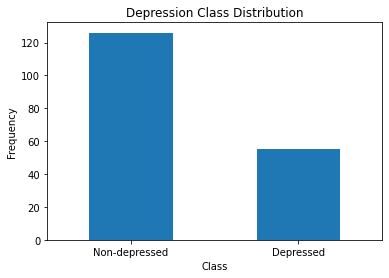

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Convert transcripts to occurrence matrix

In [3]:
CV = CountVectorizer(min_df=3) # ignore terms that appear in less than 3 documents

X = CV.fit_transform(df.Transcript).toarray()
y = df.PHQ_Binary.to_numpy()

X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]])

## Split the dataset 

In [4]:
RANDOM_STATE = 42 # lucky number

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train_val.shape, X_test.shape

((144, 2902), (37, 2902))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [5]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [6]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [7]:
def k_cross(model, X=X_train_val, y=y_train_val, k=10, n=1, random_state=42):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [8]:
def evaluate_model(model):
    model.fit(X_train_val, y_train_val)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Gaussian Naive Bayes 

[1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5419580419580419
              precision    recall  f1-score   support

           0       0.74      0.54      0.62        26
           1       0.33      0.55      0.41        11

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.52        37
weighted avg       0.62      0.54      0.56        37

Confusion Matrix: 
 [[14 12]
 [ 5  6]]


GaussianNB()

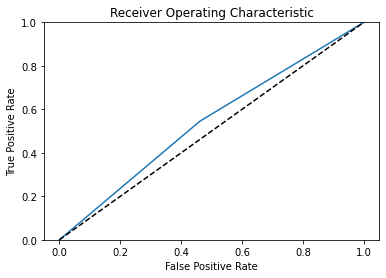

In [9]:
nb_model = GaussianNB()
evaluate_model(nb_model)

## Decision Tree

In [10]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.32333333333333336 > best f1 = -1
depth: 1, leaf: 1: recall = 0.25416666666666665 > best recall = -1
depth: 1, leaf: 21: f1 = 0.33803418803418805 > best f1 = 0.32333333333333336
depth: 1, leaf: 21: recall = 0.30416666666666664 > best recall = 0.25416666666666665
depth: 1, leaf: 22: f1 = 0.4492946922358687 > best f1 = 0.33803418803418805
depth: 1, leaf: 22: recall = 0.4374999999999999 > best recall = 0.30416666666666664
depth: 1, leaf: 23: recall = 0.5125 > best recall = 0.4374999999999999
depth: 1, leaf: 24: f1 = 0.5010695840107605 > best f1 = 0.4492946922358687
depth: 1, leaf: 24: recall = 0.6124999999999999 > best recall = 0.5125
depth: 1, leaf: 26: f1 = 0.5210695840107605 > best f1 = 0.5010695840107605
depth: 1, leaf: 26: recall = 0.6375 > best recall = 0.6124999999999999


[0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5297202797202797
              precision    recall  f1-score   support

           0       0.73      0.42      0.54        26
           1       0.32      0.64      0.42        11

    accuracy                           0.49        37
   macro avg       0.53      0.53      0.48        37
weighted avg       0.61      0.49      0.50        37

Confusion Matrix: 
 [[11 15]
 [ 4  7]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=26, random_state=42)

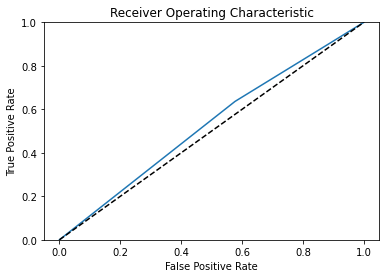

In [11]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5297202797202797
              precision    recall  f1-score   support

           0       0.73      0.42      0.54        26
           1       0.32      0.64      0.42        11

    accuracy                           0.49        37
   macro avg       0.53      0.53      0.48        37
weighted avg       0.61      0.49      0.50        37

Confusion Matrix: 
 [[11 15]
 [ 4  7]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=26, random_state=42)

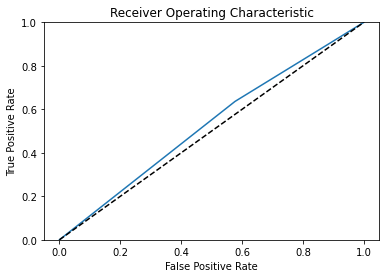

In [12]:
# Based on recall
evaluate_model(best_tree_recall_model)

## Random Forest

In [13]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.5542279942279942 > best f1 = -1
estimator: 1: recall = 0.6475 > best recall = -1
estimator: 7: recall = 0.6758333333333333 > best recall = 0.6475


[1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5227272727272727
              precision    recall  f1-score   support

           0       0.72      0.50      0.59        26
           1       0.32      0.55      0.40        11

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.60      0.51      0.53        37

Confusion Matrix: 
 [[13 13]
 [ 5  6]]


RandomForestClassifier(n_estimators=1, random_state=42)

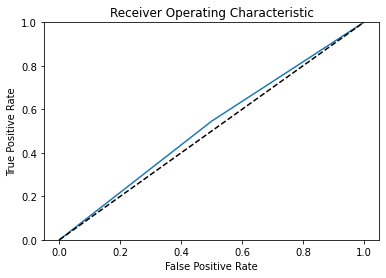

In [14]:
# Based on f1
evaluate_model(best_forest_f1_model)

[1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.458041958041958
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        26
           1       0.26      0.45      0.33        11

    accuracy                           0.46        37
   macro avg       0.46      0.46      0.44        37
weighted avg       0.55      0.46      0.48        37

Confusion Matrix: 
 [[12 14]
 [ 6  5]]


RandomForestClassifier(n_estimators=7, random_state=42)

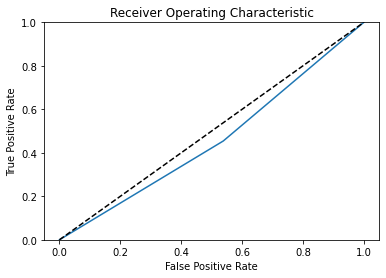

In [15]:
# Based on recall
evaluate_model(best_forest_recall_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    9.0s finished


[0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5472027972027973
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.36      0.36      0.36        11

    accuracy                           0.62        37
   macro avg       0.55      0.55      0.55        37
weighted avg       0.62      0.62      0.62        37

Confusion Matrix: 
 [[19  7]
 [ 7  4]]
Best SVM parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


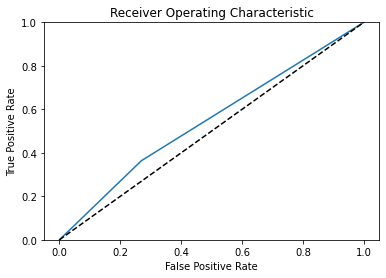

In [16]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")